# Computational Quantum Dynamics

__This project has been carried out by:__ Mathieu Kaltschmidt and Carl von Randow


## The Gross-Pitaevskii equation (GPE): Dynamics of solitons and vortices

The GPE is a mean field equation that has been incredibly successful in describing the dynamics of Bose Einstein condensates (BECs). The equation features a non-linear term and thus allows for stable soliton solutions in 1D and additional topological defects such as vortices in 2D. The goal of this project is to study these phenomena using the split-step Fourier method.

## 1) The evolution of dark solitons in a homogeneous 1D Bose gas

- Insert a sufficient description here: 
- What are "dark solitons"? (de)
- Which potential should be chosen?
- Introducing the GPE
- Some theory..

## 2) Dynamics of solitons in a homogeneous 2D Bose gas.

## 3) Topological defects: Studying the behaviour of vortices in a 2D gas

In [3]:
#Settings and useful packages
import matplotlib as mpl
mpl.rcParams['legend.handlelength'] = 0.5
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import h5py as h
import scipy.special as special
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit, newton
from scipy.interpolate import interp1d
import scipy.optimize as optimization
import timeit


Mymarkersize = 3.5
myfontsize = 9

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'], 'size':myfontsize})
rc('text', usetex=True)
rc('legend', fontsize=9.0)

### Tools for the vortex grids 

In [ ]:
#create a grid with homogeneous condensate background density
def create_condensed_grid(nx_grid,ny_grid,N):
    grid = np.zeros((nx_grid,ny_grid), 'complex') #initialize grid in Fourier space
    grid[0,0] = np.sqrt(N/2.) + 1j*np.sqrt(N/2.) #fill condensate mode k=0 with all particles
    grid = np.fft.fft2(grid)/np.sqrt(nx_grid*ny_grid) #Fourier transform
    return grid


#calculate the total number of particles on the grid
def calculate_particle_number(grid):
    return np.sum(np.sum(np.abs(grid)**2,axis=0), axis=0)


#Vortex with winding number n = +- 1
def add_2d_vortex_simple(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print(xi)
    for x2 in np.arange(0,grid.shape[0]):
        for y2 in np.arange(0,grid.shape[1]):
            rho = x_pos-x2 + 1j*n*(y_pos-y2)        ### shape of the vortex, rho = 0 at the core, i.e. if x_pos = x2 and y_pos = y2
            grid_h[x2,y2] *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi)) * rho    #### multiply homogeneous background field with shape of vortex        
    return grid_h

#Vortex with winding number n  
def add_2d_vortex_simple_n(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print xi

    sn = (int) (n/np.sqrt(n*n))
    wn = (int) (np.sqrt(n*n))
    
    for x2 in np.arange(0,grid.shape[0]):
        
        for y2 in np.arange(0,grid.shape[1]):
            
            rho = x_pos-x2 + 1j*sn*(y_pos-y2)
            rho *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi))
            rho = rho**wn
            
            grid_h[x2,y2] *= rho
        
    return grid_h


def add_2d_vortex(grid, x_pos, y_pos, n, N, g):
    """ 
    add a single vortex to the grid 
    @params:
    grid : numerical real space grid
    x_pos : x-position of vortex
    y_pos : y-position of vortex
    n : quantization of vortex
    N : total particle number
    g : non-linear coupling
    """
    grid_h = grid
    if((int) (np.sqrt(n*n)) == 1):

        print("Only single quantized vortices")
        
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos, n, N, g)
        #Adding "mirror vortices" on all 8 adjacent cells to respect periodic boundaries:
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N, g)

    else:

        print("Vortices with higher quantization")
        
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N,g)
        
    return grid_h

def create_2d_random_vortexpair_grid(nx_grid,ny_grid,num_vortex_pairs,N,g):
    """
    Function creates a grid with randomly placed singly quantized vortices, equal number of vortices with n=1 and antivortices with n=-1
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    num_vortex_pairs : number of vortex pairs with quantization n= +-1 on the grid
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortex_pairs):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), 1, N ,g)
        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), -1, N ,g)

    return grid


def create_2d_random_vortex_grid(nx_grid,ny_grid,num_vortices,n,N,g):
    """
    function creates a grid with randomly placed n-quantized vortices, equal quantization of all vortices 
    """
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortices):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), n, N ,g)

    return grid

def create_2d_regular_vortex_grid(nx_grid,ny_grid,lx,ly,n,N,g):
    """
    Function creates a grid with a regular vortex configuration, vortices can also be highly quantized (n>1 or n<-1), arrangement in a checkerboard manner, i.e. vortices would correspond
    for example to black fields and antivortices to white fields of a checkerboard
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    lx : number of defects in x-direction of checkerboard
    ly : number of defects in y-direction of checkerboard
    n : quantization of the vortices
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    dist_x = 1.*nx_grid/lx
    dist_y = 1.*ny_grid/ly

    print(dist_x)
    
    sy = 1
    for x in np.arange(1,lx+1):

        sx = 1
        for y in np.arange(1,ly+1):

            grid = add_2d_vortex(grid, dist_x*x, dist_y*y, sy*sx*n, N,g)
            sx *= -1

        sy*= -1

    return grid

### Initializing the vortex grids

Homogeneous background density: 3.125
Particle number:  12800.0
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Only single quantized vortices
Particle number on created vortex grid:  12800.0


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


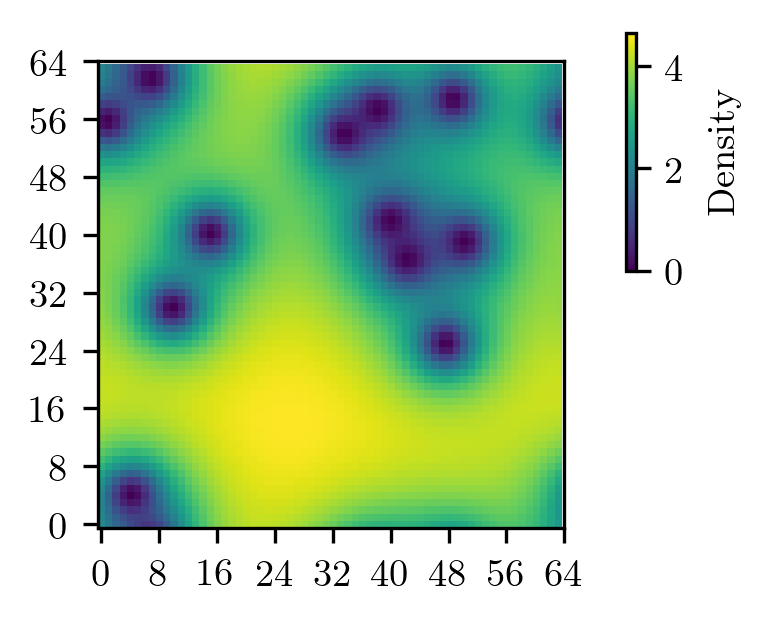

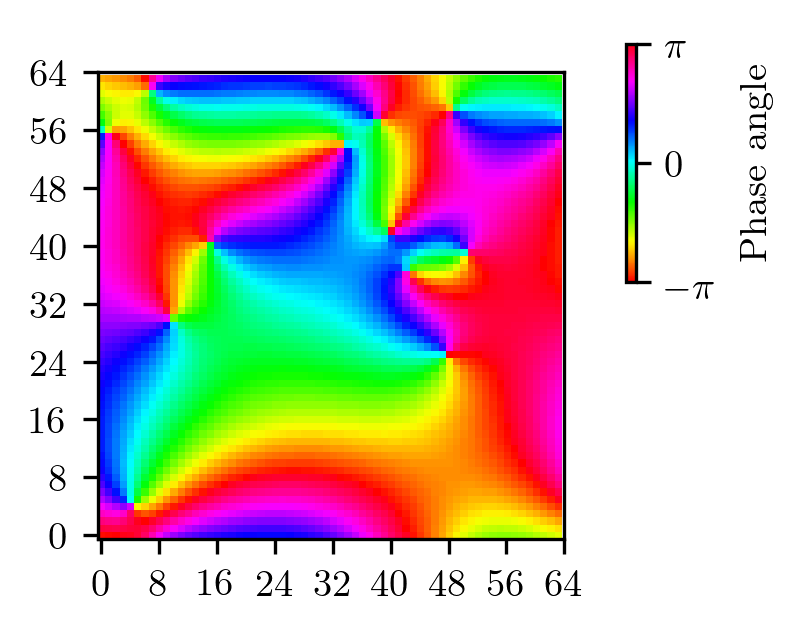

In [22]:
def main(argv):
    """
    Main program to initialize a vortex grid
    """
    do_random_vortexpair_grid = True      ### if True initial grid will be vortex grid with an equal number of vortices and antivortices placed at random positions
    do_random_vortex_grid = False         ### if True initial grid will be vortex grid composed of vortices with equal quantization placed at random positions
    do_regular_vortex_grid = False        ### if True initial grid will be regular vortex grid, i.e. equal distances between vortices and antivortices
    
    nx_grid = 64    ### number of grid points in x-direction
    ny_grid = 64    ### number of grid points in y-direction

    xi = 4          ### healing length, resolved with 4 grid points, if you use a small grid you can go down to 2 grid points
    g = 1e-2        ### non-linear GPE coupling
    rho = 1./(2*g*xi**2)    ### homogeneous background density
    print("Homogeneous background density:" , rho)
    
    N = rho*nx_grid*ny_grid   ### total particle number of simulation
    print("Particle number: " , N)

    if(do_random_vortexpair_grid):

        num_vortex_pairs = 6     ### number of vortex pairs with quantization n = +-1 
        grid = create_2d_random_vortexpair_grid(nx_grid,ny_grid, num_vortex_pairs, N,g)

    if(do_random_vortex_grid):

        num_vortices = 10     ### total number of vortices
        n = 2                 ### quantization of vortices
        grid = create_2d_random_vortex_grid(nx_grid,ny_grid, num_vortices,n, N,g)

    if(do_regular_vortex_grid):
        lx = 2     ### number of vortices in x-direction on checkerboard
        ly = 2     ### number of vortices in y-direction on checkerboard
        n = 4      ### quantization of the vortices 
        grid = create_2d_regular_vortex_grid(nx_grid, ny_grid, lx, ly, n, N, g)

        
    grid *= np.sqrt(1.*N/calculate_particle_number(grid))               ### normalize to initially set particle number
    print("Particle number on created vortex grid: " , calculate_particle_number(grid))

    
    """ 
    Visualization of the initial grid 
    """
    
    fulllengthy = ny_grid
    factory = 8.
    stepsy = (int)(fulllengthy/factory)
    maxLengthy = (int)(ny_grid*(stepsy*factory)/fulllengthy)

    xtick_locs = np.r_[0:maxLengthy:1j*(stepsy+1)]
    xtick_lbls = np.r_[0:stepsy*factory:1j*(stepsy+1)]

    fulllengthx = nx_grid
    factorx = 8.
    stepsx = (int)(fulllengthx/factorx)
    maxLengthx = (int)(nx_grid*(stepsx*factorx)/fulllengthx)

    ytick_locs = np.r_[0:maxLengthx:1j*(stepsx+1)]
    ytick_lbls = np.r_[0:stepsx*factorx:1j*(stepsx+1)]     

    """
    Density 
    """
    
    fig, axes = plt.subplots(1,1,sharex=True)
    plt.gcf().subplots_adjust(bottom=0.16)
    fig.set_dpi(300)
    fig.set_size_inches(2.2,2.2)

    im = axes.imshow(np.abs(grid)**2,interpolation='nearest', origin='lower left', label = r'', vmin=0, vmax=(np.abs(grid)**2).max())

    cax = fig.add_axes([1, 0.6, 0.015, 0.72/2.])
    cb =  fig.colorbar(im,cax=cax,orientation='vertical')
    cb.set_label(r'Density',labelpad=5)
    

    plt.setp(axes, xticks=xtick_locs, xticklabels=xtick_lbls.astype(int),
             yticks=ytick_locs, yticklabels=ytick_lbls.astype(int))


    plt.gcf().subplots_adjust(bottom=0.2)
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    #plt.show()

    """
    Phase
    """
    
    fig, axes = plt.subplots(1,1,sharex=True)
    plt.gcf().subplots_adjust(bottom=0.16)
    fig.set_dpi(300)
    fig.set_size_inches(2.2,2.2)

    im = axes.imshow(np.angle(grid),interpolation='nearest', origin='lower left', label = r'', vmin=-np.pi, vmax=np.pi, cmap ='hsv')

    
    cax = fig.add_axes([1, 0.6, 0.015, 0.72/2.])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '0', '$\pi$'])
    cbar.set_label(r'Phase angle',labelpad=5)
    

    plt.setp(axes, xticks=xtick_locs, xticklabels=xtick_lbls.astype(int),
             yticks=ytick_locs, yticklabels=ytick_lbls.astype(int))


    plt.gcf().subplots_adjust(bottom=0.2)
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()
    
    
if __name__=='__main__':
    main(sys.argv)